In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Use GPU:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

tf.test.gpu_device_name()

''

Install StellarGraph:

In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph.calibration import expected_calibration_error, plot_reliability_diagram
from stellargraph.calibration import IsotonicCalibration, TemperatureCalibration

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression


from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
from  stellargraph import StellarGraph
import pandas as pd


%matplotlib inline

Import data and split between years to predict and years to train:

In [ ]:
import random
import numpy as np
from  stellargraph import StellarGraph
import pandas as pd

#load the data
author_codes = np.load("/content/drive/MyDrive/scopus/data_scopus/author_codes.npy", allow_pickle = True)
affiliations = np.load("/content/drive/MyDrive/scopus/data_scopus/affiliations.npy", allow_pickle = True)
deg = np.load("/content/drive/MyDrive/scopus/data_scopus/deg.npy",allow_pickle = True)
har_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/har_cen.npy",allow_pickle = True)
deg_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/deg_cen.npy",allow_pickle = True)
clos_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/clos_cen.npy",allow_pickle = True)
bet_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/bet_cen.npy",allow_pickle = True)
load_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/load_cen.npy",allow_pickle = True)
pagerank = np.load("/content/drive/MyDrive/scopus/data_scopus/pagerank.npy",allow_pickle = True)
nodes_index = np.load("/content/drive/MyDrive/scopus/data_scopus/nodes_index.npy",allow_pickle = True)
source = np.load("/content/drive/MyDrive/scopus/data_scopus/source.npy",allow_pickle = True)

target = np.load("/content/drive/MyDrive/scopus/data_scopus/target.npy",allow_pickle = True)
years = np.load("/content/drive/MyDrive/scopus/data_scopus/years.npy",allow_pickle = True)
collabs = np.load("/content/drive/MyDrive/scopus/data_scopus/collabs.npy",allow_pickle = True)
edge_load_cen = np.load("/content/drive/MyDrive/scopus/data_scopus/edge_load_cen.npy",allow_pickle = True)


source_train = []
target_train = []
years_train = []
collabs_train = []
edge_load_cen_train = []

source_val = []
target_val = []
years_val = []
collabs_val = []
edge_load_cen_val = []

source_test = []
target_test = []
years_test = []
collabs_test = []
edge_load_cen_test = []

p_size = 3
j = 1
for i in range(len(years)):
  if(years[i] == 2016):
    years_test.append(years[i])
    source_test.append(source[i])
    target_test.append(target[i])
    collabs_test.append(collabs[i])
    edge_load_cen_test.append(edge_load_cen[i])
  else:
    if(j % (p_size*10) == 0):
      years_train.append(years[i])
      source_train.append(source[i])
      target_train.append(target[i])
      collabs_train.append(collabs[i])
      edge_load_cen_train.append(edge_load_cen[i])
    j+=1

StellarGraph: Undirected multigraph
 Nodes: 2668, Edges: 117633

 Node types:
  default: [2668]
    Features: float32 vector, length 9
    Edge types: default-default->default

 Edge types:
    default-default->default: [117633]
        Weights: all 1 (default)
        Features: float32 vector, length 3
StellarGraph: Undirected multigraph
 Nodes: 2668, Edges: 29410

 Node types:
  default: [2668]
    Features: float32 vector, length 9
    Edge types: default-default->default

 Edge types:
    default-default->default: [29410]
        Weights: all 1 (default)
        Features: float32 vector, length 3


Split graph into train-val-test:

In [ ]:
square_node_data = pd.DataFrame( 
    {"author_code": author_codes,"affiliations": affiliations, "degree":deg, "harmonic_centrality":har_cen, "degree_centrality":deg_cen, 
    "closeness_centrality": clos_cen, "betweenness_centrality":bet_cen, "load_centrality":load_cen,
     "pagerank": pagerank},
     index = nodes_index)

square_edges_train = pd.DataFrame( 
    {"source": source_train, "target": target_train, "year": years_train, "collab": collabs_train, "load_centrality": edge_load_cen_train}
)

G_train = StellarGraph(square_node_data, square_edges_train) 
print(G_train.info())

square_edges_test = pd.DataFrame( 
    {"source": source_test, "target": target_test, "year": years_test, "collab": collabs_test, "load_centrality": edge_load_cen_test}
)

G_test = StellarGraph(square_node_data, square_edges_test) #build graph
print(G_test.info())

# train, test, validation split
train_size = 0.75 
val_size = 0.09
test_size = 0.9

edge_splitter_test = EdgeSplitter(G_test)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True)

edge_splitter_val = EdgeSplitter(G_train)

G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True)

edge_splitter_train = EdgeSplitter(G_val)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True)

StellarGraph: Undirected multigraph
 Nodes: 2668, Edges: 117633

 Node types:
  default: [2668]
    Features: float32 vector, length 9
    Edge types: default-default->default

 Edge types:
    default-default->default: [117633]
        Weights: all 1 (default)
        Features: float32 vector, length 3
StellarGraph: Undirected multigraph
 Nodes: 2668, Edges: 29410

 Node types:
  default: [2668]
    Features: float32 vector, length 9
    Edge types: default-default->default

 Edge types:
    default-default->default: [29410]
        Weights: all 1 (default)
        Features: float32 vector, length 3
** Sampled 26469 positive and 26469 negative edges. **
** Sampled 10586 positive and 10586 negative edges. **
** Sampled 80285 positive and 80285 negative edges. **


Train the model:

In [ ]:
epochs = 3000

train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

val_gen = FullBatchLinkGenerator(G_val, method="gcn")
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)

test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)


gcn = GCN(layer_sizes=[10,16,32,64,16,8,64,512], 
          activations=["softmax","relu","relu","elu","relu","softmax","elu","relu"], generator=train_gen, dropout=0.3)

x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0005),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],)
reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.8, patience=50, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=500)

history = model.fit(
    train_flow,steps_per_epoch = len(train_flow), epochs=epochs,callbacks=[early_stop, reduce_lr], validation_data=val_flow, validation_steps = len(val_flow), verbose=2, shuffle=True)

Epoch 1/3000
1/1 - 4s - loss: 0.7824 - binary_accuracy: 0.5066 - val_loss: 0.7186 - val_binary_accuracy: 0.5191 - lr: 5.0000e-04 - 4s/epoch - 4s/step
Epoch 2/3000
1/1 - 2s - loss: 0.7442 - binary_accuracy: 0.5133 - val_loss: 0.6786 - val_binary_accuracy: 0.5355 - lr: 5.0000e-04 - 2s/epoch - 2s/step
Epoch 3/3000
1/1 - 2s - loss: 0.6971 - binary_accuracy: 0.5305 - val_loss: 0.6471 - val_binary_accuracy: 0.5683 - lr: 5.0000e-04 - 2s/epoch - 2s/step
Epoch 4/3000
1/1 - 2s - loss: 0.6649 - binary_accuracy: 0.5612 - val_loss: 0.6247 - val_binary_accuracy: 0.6059 - lr: 5.0000e-04 - 2s/epoch - 2s/step
Epoch 5/3000
1/1 - 1s - loss: 0.6459 - binary_accuracy: 0.6045 - val_loss: 0.6149 - val_binary_accuracy: 0.6471 - lr: 5.0000e-04 - 1s/epoch - 1s/step
Epoch 6/3000
1/1 - 2s - loss: 0.6501 - binary_accuracy: 0.6344 - val_loss: 0.6171 - val_binary_accuracy: 0.6708 - lr: 5.0000e-04 - 2s/epoch - 2s/step
Epoch 7/3000
1/1 - 1s - loss: 0.6558 - binary_accuracy: 0.6481 - val_loss: 0.6198 - val_binary_accur

Evaluate the trained model:

1/1 [==============================] - 0s 258ms/step - loss: 0.6994 - binary_accuracy: 0.6437

Train Set Metrics of the trained model:
	loss: 0.6366
	binary_accuracy: 0.6499

Validation Set Metrics of the trained model:
	loss: 0.6178
	binary_accuracy: 0.6752

Test Set Metrics of the trained model:
	loss: 0.6994
	binary_accuracy: 0.6437


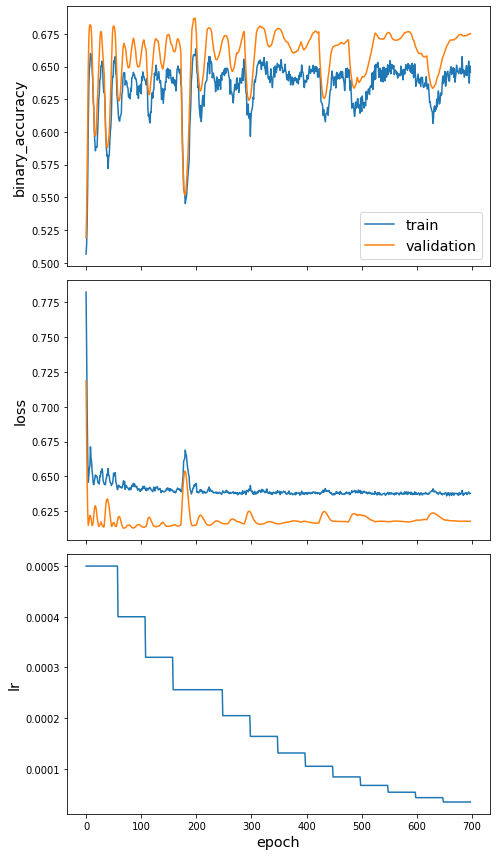

In [ ]:
sg.utils.plot_history(history)

train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))